In [ ]:
!pip install powerlaw
!pip install scipy


Using device: cuda Tesla T4


σ=1.0, step: 100%|██████████| 140000/140000 [01:26<00:00, 1611.88it/s]


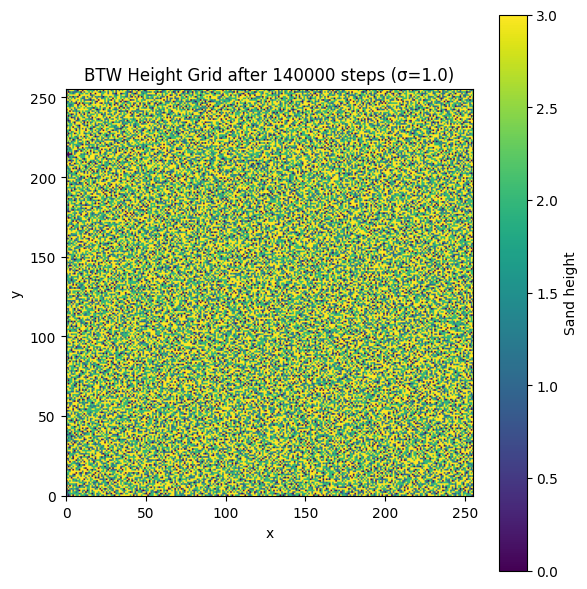

In [ ]:
# 1. GPU check
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device,
      torch.cuda.get_device_name(0) if torch.cuda.is_available() else "")

# 2. Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

# 3. Core of the BTW model (vectorized), return final grid state
def simulate_btw_gpu_vectorized_return_grid(L, sigma, n_steps, device):

    # Initialize a 1×1×L×L grid tensor (representing heights)
    grid = torch.zeros((1, 1, L, L), dtype=torch.int32, device=device)

    # 3×3 convolution kernel: four neighbors (up, down, left, right)
    conv_kernel = torch.tensor(
        [[0, 1, 0],
         [1, 0, 1],
         [0, 1, 0]],
        dtype=torch.int32, device=device
    ).view(1, 1, 3, 3)

    for step in tqdm(range(n_steps), desc=f"σ={sigma}, step"):
        # Randomly add one grain of sand at (i, j)
        i = torch.randint(0, L, (1,), device=device)
        j = torch.randint(0, L, (1,), device=device)
        grid[0, 0, i, j] += 1

        # Mark variables such as the number of toppling rounds caused by this drop
        while True:
            unstable = (grid >= 4)
            if not unstable.any():
                break

            # Compute topple_count for each cell = floor(height / 4)
            topple_count = (grid // 4).to(torch.int32)   # Shape: 1×1×L×L
            tc2d = topple_count[0, 0].float()            # Convert to float for convolution

            # Subtract 4 * topple_count from heights
            grid = grid - (topple_count * 4)

            # (1) Unbiased distribution: perform a single 2D convolution
            neighbors_sum = F.conv2d(
                tc2d.view(1, 1, L, L), conv_kernel.float(), padding=1
            ).to(torch.int32)  # Shape: 1×1×L×L
            grid = grid + neighbors_sum

            # (2) Biased distribution: distribute extra bias_amount towards +x direction
            bias_amount = (tc2d * (4 * sigma / (4 + sigma))).floor().to(torch.int32)  # Shape: L×L
            ba4 = bias_amount.view(1, 1, L, L)  # Shape: 1×1×L×L
            shifted = torch.zeros_like(grid)     # Shape: 1×1×L×L
            shifted[..., :, :, 1:] = ba4[..., :, :, :-1]  # Shift towards +x
            grid = grid + shifted

            # Continue to the next relaxation round

        # End of this step, proceed to the next sand addition

    # Return the final height matrix (L×L)
    return grid[0, 0].cpu().numpy()


# 4. Run the simulation and visualize the grid after 140,000 steps
L       = 256
sigma   = 1.0
n_steps = 140000

final_grid = simulate_btw_gpu_vectorized_return_grid(L, sigma, n_steps, device)

# 5. Plot heatmap using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(final_grid, cmap='viridis', origin='lower')
plt.colorbar(label='Sand height')
plt.title(f"BTW Height Grid after {n_steps} steps (σ={sigma})")
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import powerlaw
from tqdm import tqdm

# 1. GPU detection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device,
      torch.cuda.get_device_name(0) if torch.cuda.is_available() else "")

# 2. Discrete K–S p-value function
def discrete_ks_pvalue(data_tail, alpha, xmin, num_sim=200):
    data = np.array(data_tail)
    data = data[data >= xmin].astype(int)
    n = len(data)
    if n == 0:
        return 0.0, 1.0
    xs = np.arange(xmin, data.max() + 1)
    pmf = xs**(-alpha)
    pmf /= pmf.sum()
    cdf_model = np.cumsum(pmf)
    freqs = np.bincount(data - xmin, minlength=len(xs))
    cdf_emp = np.cumsum(freqs) / n
    D_obs = np.max(np.abs(cdf_emp - cdf_model))
    count = 0
    for _ in range(num_sim):
        synth = np.random.choice(xs, size=n, p=pmf)
        freqs_sim = np.bincount(synth - xmin, minlength=len(xs))
        cdf_sim = np.cumsum(freqs_sim) / n
        if np.max(np.abs(cdf_sim - cdf_model)) >= D_obs:
            count += 1
    return D_obs, (count + 1) / (num_sim + 1)

# 3. Core simulation function: mass conservation, boundary loss, fractional–integer accumulation
def simulate_btw_gpu_vectorized(L, sigma, n_drops, burn_in, device):
    # 3.1 Initialize height grid and remainder matrix
    grid = torch.zeros((1, 1, L, L), dtype=torch.float32, device=device)
    remainder = torch.zeros_like(grid)

    # 3.2 Build the biased convolution kernel K*
    w_base  = 4.0 / (4.0 + sigma)
    w_right = 4.0 * sigma / (4.0 + sigma)
    Kstar = torch.tensor([
        [0.0,      w_base, 0.0],
        [w_base,   0.0,    w_right],
        [0.0,      w_base, 0.0]
    ], dtype=torch.float32, device=device).view(1, 1, 3, 3)

    sizes, areas, losses, lengths, durations = [], [], [], [], []

    for drop in tqdm(range(n_drops), desc=f"σ={sigma}"):
        # 3.3 Randomly drop one grain
        i = torch.randint(0, L, (1,), device=device).item()
        j = torch.randint(0, L, (1,), device=device).item()
        grid[0, 0, i, j] += 1.0

        # Statistics for this avalanche
        toppled = torch.zeros((L, L), dtype=torch.bool, device=device)
        loss = 0
        dur = 0
        size = 0

        # 3.4 Relaxation loop
        while True:
            unstable = grid >= 4.0
            if not unstable.any():
                break
            dur += 1

            # 3.4.1 Compute number of topplings T
            T = torch.floor(grid / 4.0)  # float32

            # 3.4.2 Subtract 4·T from the grid
            grid = grid - 4.0 * T

            # 3.4.3 Distribute 4·T grains via convolution with K*
            delta = F.conv2d(T, Kstar, padding=1)  # float32

            # 3.4.4 Fractional–integer accumulation and flooring
            remainder = remainder + delta
            D = torch.floor(remainder)               # integer part
            remainder = remainder - D

            # 3.4.5 Update heights & account for boundary loss
            grid = grid + D
            # Grains in the rightmost column of D are those that fell off the edge
            loss += int(D[0,0,:,-1].sum().item())

            # 3.4.6 Accumulate toppled area and avalanche size
            toppled |= unstable[0,0]
            size    += int((T.sum() * 4.0).item())

        # 3.5 Record metrics after burn-in period
        if drop >= burn_in:
            sizes   .append(size)
            durations.append(dur)
            areas   .append(int(toppled.sum().item()))
            losses  .append(loss)
            if toppled.any():
                coords = torch.nonzero(toppled, as_tuple=False)
                span = (torch.abs(coords[:,0]-i) +
                        torch.abs(coords[:,1]-j))
                lengths.append(int(span.max().item()))
            else:
                lengths.append(0)

    return (
        np.array(sizes),
        np.array(areas),
        np.array(losses),
        np.array(lengths),
        np.array(durations),
    )

# 4. Main routine: run simulations for different sigma, fit power-law, perform K–S test
def run_simulation():
    L, n_drops, burn_in = 256, 200_000, 140_000
    metrics = {}
    sigma_list = [0.0, 1.0, 2.0, 3.0, 5.0]

    ks_stats = {'sigma': [], 'D_size': [], 'p_size': [], 'D_dur': [], 'p_dur': []}
    for sigma in sigma_list:
        sizes, areas, losses, lengths, durations = simulate_btw_gpu_vectorized(
            L, sigma, n_drops, burn_in, device
        )

        # Avalanche size fit
        tail_s = sizes[sizes > 0]
        fit_s  = powerlaw.Fit(tail_s, xmin=1, discrete=True, verbose=False)
        D_s, p_s = discrete_ks_pvalue(
            tail_s[tail_s >= fit_s.xmin], fit_s.power_law.alpha, int(fit_s.xmin)
        )

        # Avalanche duration fit
        tail_t = durations[durations > 0]
        fit_t  = powerlaw.Fit(tail_t, xmin=1, discrete=True, verbose=False)
        D_t, p_t = discrete_ks_pvalue(
            tail_t[tail_t >= fit_t.xmin], fit_t.power_law.alpha, int(fit_t.xmin)
        )

        # Record metrics
        metrics[sigma] = {
            'sizes': sizes, 'areas': areas,
            'losses': losses, 'lengths': lengths,
            'durations': durations
        }

        ks_stats['sigma'].append(sigma)
        ks_stats['D_size'].append(D_s); ks_stats['p_size'].append(p_s)
        ks_stats['D_dur'].append(D_t);   ks_stats['p_dur'].append(p_t)

        print(
            f"σ={sigma:.1f} → "
            f"size:  D={D_s:.3f}, p={p_s:.3f} | "
            f"dur:   D={D_t:.3f}, p={p_t:.3f}"
        )
    return ks_stats, metrics

# 5. Execute
if __name__ == "__main__":
    stats, metrics = run_simulation()
    print("\nK–S statistics:", stats)


Using device: cuda Tesla T4


σ=0.0: 100%|██████████| 200000/200000 [01:13<00:00, 2719.87it/s]


σ=0.0 → size:  D=0.532, p=0.005 | dur:   D=0.145, p=0.005


σ=1.0: 100%|██████████| 200000/200000 [01:07<00:00, 2948.87it/s]


σ=1.0 → size:  D=0.542, p=0.005 | dur:   D=0.101, p=0.005


σ=2.0: 100%|██████████| 200000/200000 [01:13<00:00, 2721.20it/s]


σ=2.0 → size:  D=0.528, p=0.005 | dur:   D=0.158, p=0.005


σ=3.0: 100%|██████████| 200000/200000 [01:13<00:00, 2727.67it/s]


σ=3.0 → size:  D=0.512, p=0.005 | dur:   D=0.147, p=0.005


σ=5.0: 100%|██████████| 200000/200000 [01:20<00:00, 2483.99it/s]


σ=5.0 → size:  D=0.483, p=0.005 | dur:   D=0.168, p=0.005

K–S statistics: {'sigma': [0.0, 1.0, 2.0, 3.0, 5.0], 'D_size': [np.float64(0.5322964298789824), np.float64(0.5424505067164557), np.float64(0.5279793715847346), np.float64(0.5124132357987026), np.float64(0.4827583870376571)], 'p_size': [0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453], 'D_dur': [np.float64(0.14510106730229433), np.float64(0.10119907393994615), np.float64(0.15817000303821438), np.float64(0.14665196858077478), np.float64(0.16848630074963983)], 'p_dur': [0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453, 0.004975124378109453]}


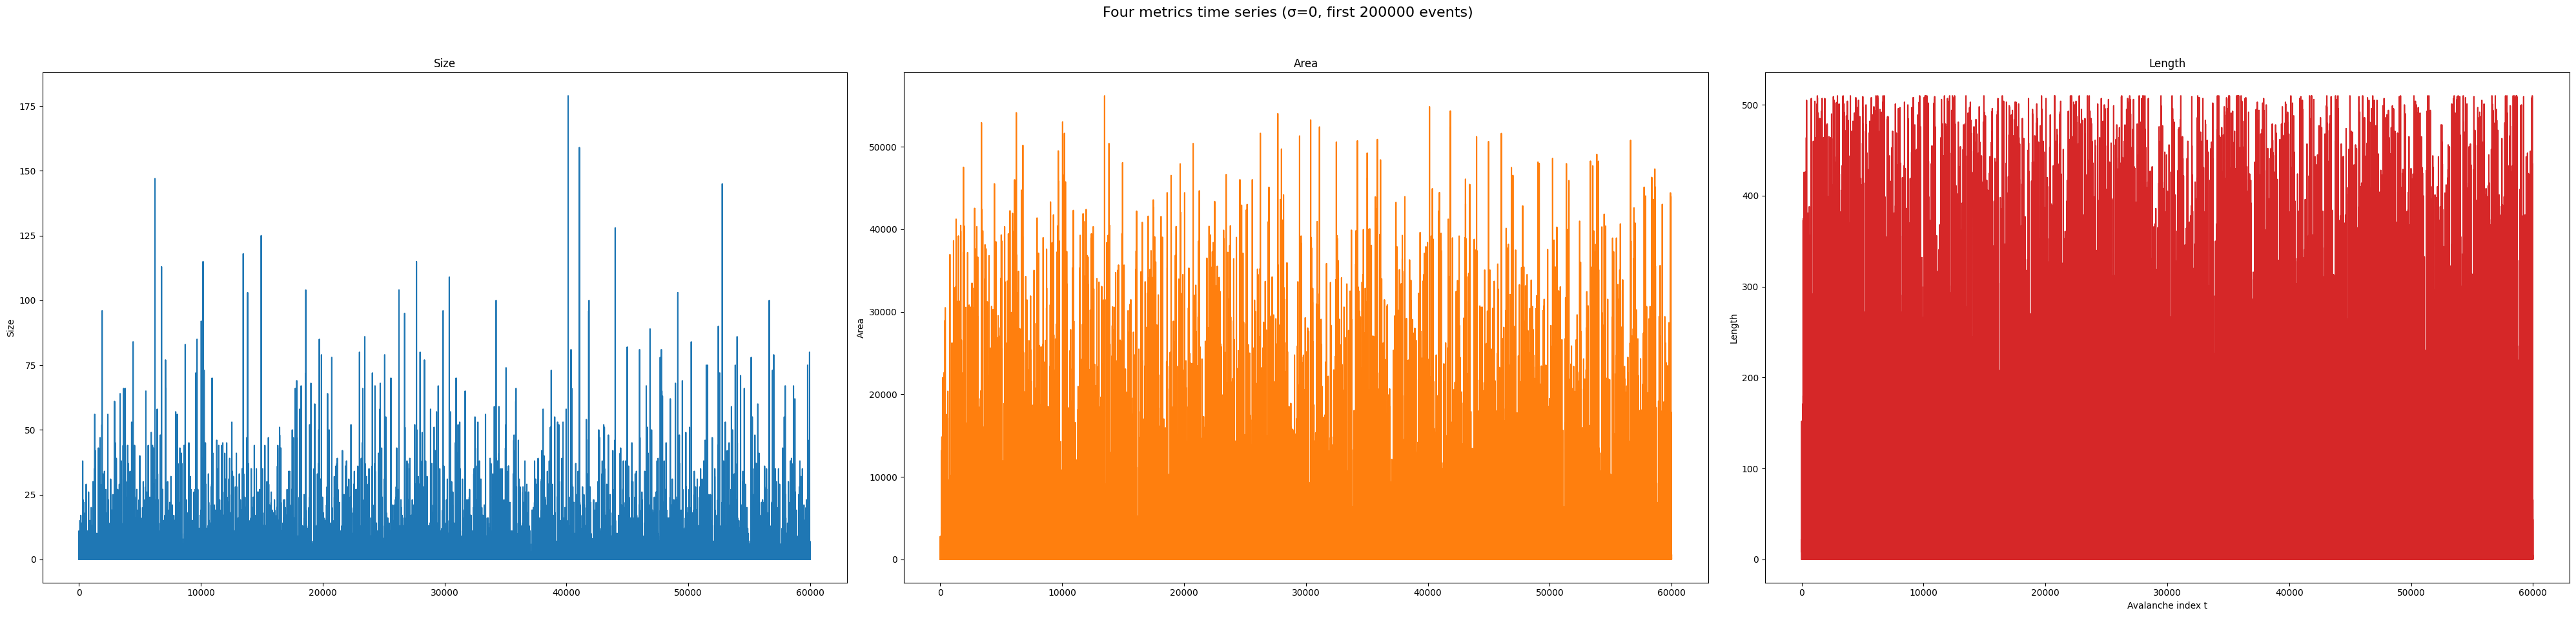

In [ ]:
# Time- frequency
sigma0, T = 0, 200000
data0 = metrics[sigma0]

# Create a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(40, 10), sharex=True)
fig.suptitle(f'Four metrics time series (σ={sigma0}, first {T} events)', fontsize=16)

# Size: Access the first subplot (index 0)
axs[0].plot(data0['sizes'][:T], color='tab:blue')
axs[0].set_title('Size')
axs[0].set_ylabel('Size')

# Area: Access the second subplot (index 1)
axs[1].plot(data0['areas'][:T], color='tab:orange')
axs[1].set_title('Area')
axs[1].set_ylabel('Area')

axs[2].plot(data0['lengths'][:T], color='tab:red')
axs[2].set_title('Length')
axs[2].set_ylabel('Length')
axs[2].set_xlabel('Avalanche index t')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

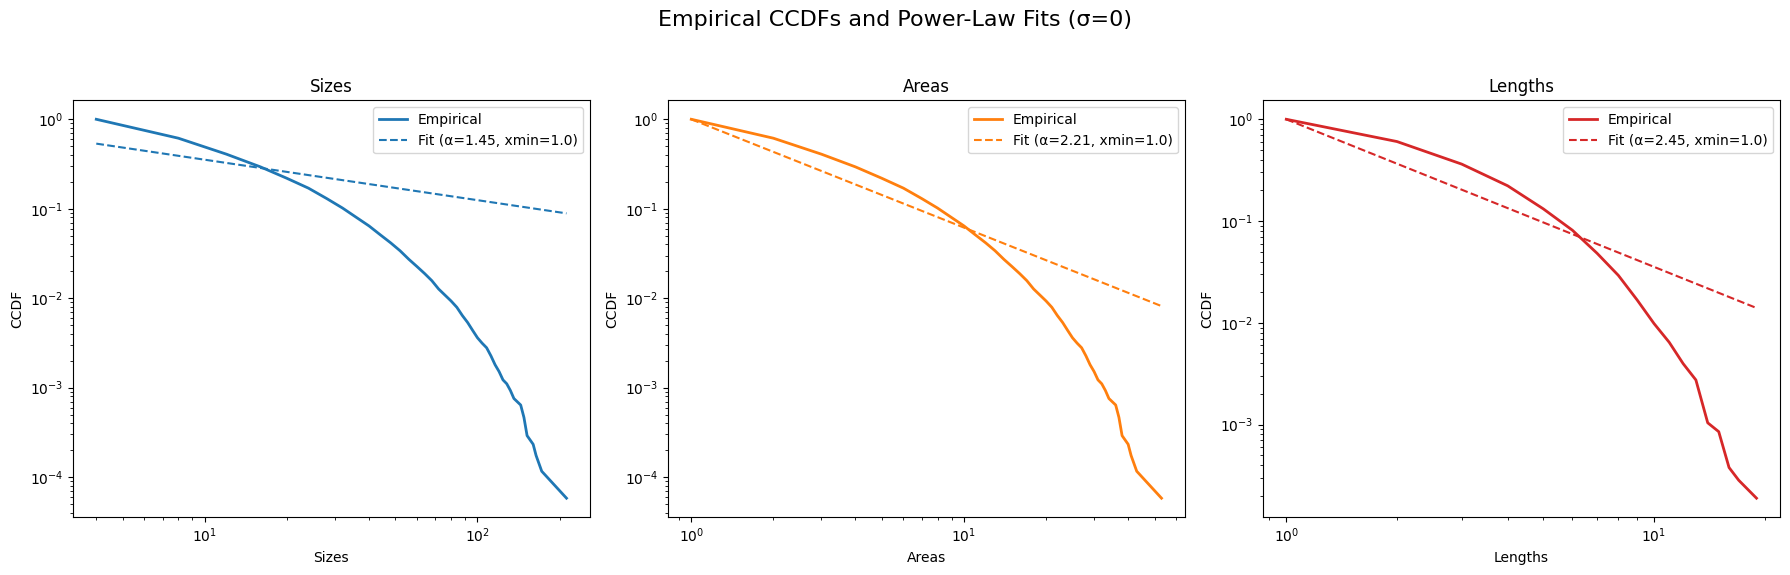

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

# Parameters
sigma0 = 0
T = 100_000
data0 = metrics[sigma0]
metrics_names = ['sizes', 'areas', 'lengths']
colors = ['tab:blue', 'tab:orange', 'tab:red']

# Create a 1×3 subplot layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Empirical CCDFs and Power-Law Fits (σ={sigma0})', fontsize=16)

for ax, m, c in zip(axs, metrics_names, colors):
    # Prepare data
    ts = data0[m][:T]
    ts = ts[ts > 0]

    # Fit power-law
    fit = powerlaw.Fit(ts, xmin=1, verbose=False)
    alpha = fit.power_law.alpha
    xmin = fit.xmin

    # Plot empirical CCDF
    fit.plot_ccdf(ax=ax, color=c, label='Empirical', linewidth=2)
    # Plot fitted power-law CCDF
    fit.power_law.plot_ccdf(
        ax=ax,
        color=c,
        linestyle='--',
        label=f'Fit (α={alpha:.2f}, xmin={xmin})'
    )

    ax.set_title(m.capitalize())
    ax.set_xlabel(m.capitalize())
    ax.set_ylabel('CCDF')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


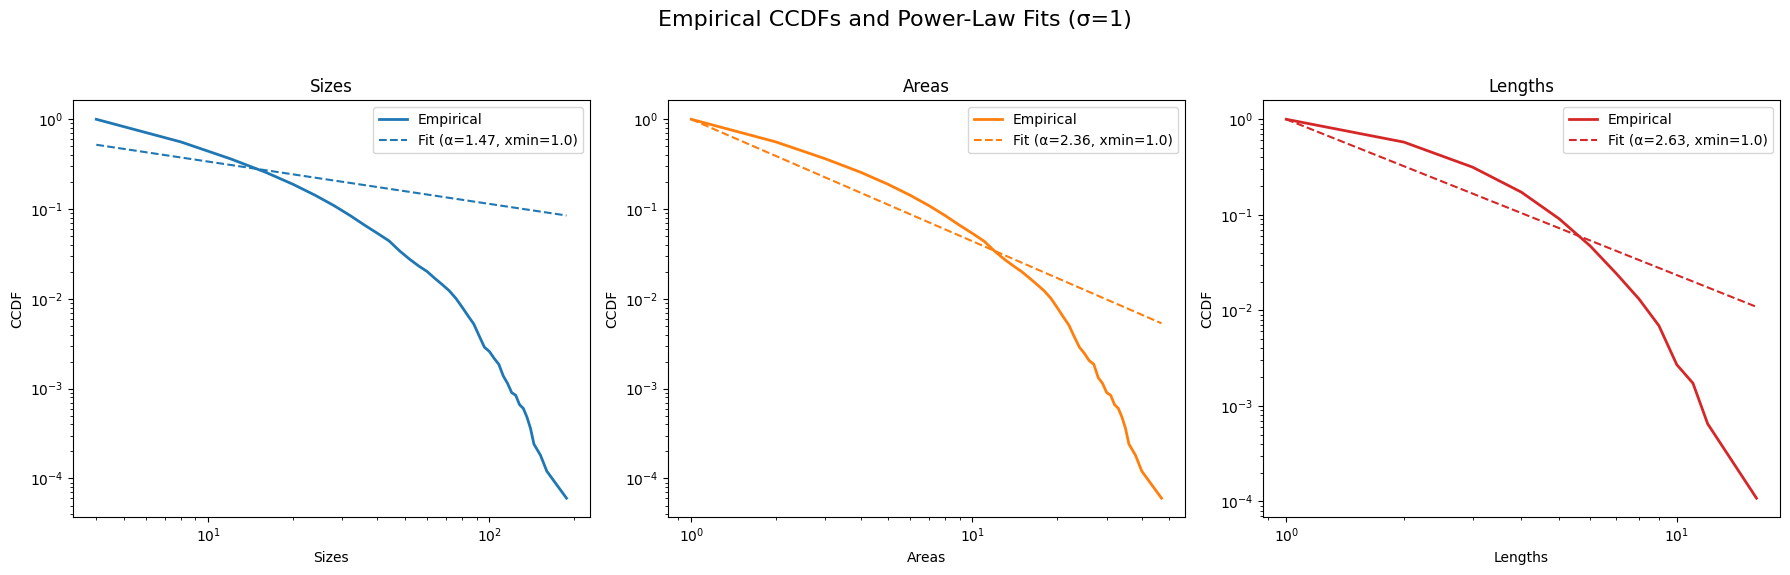

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

# Parameters
sigma0 = 1
T = 100_000
data0 = metrics[sigma0]
metrics_names = ['sizes', 'areas', 'lengths']
colors = ['tab:blue', 'tab:orange', 'tab:red']

# Create a 1×3 subplot layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Empirical CCDFs and Power-Law Fits (σ={sigma0})', fontsize=16)

for ax, m, c in zip(axs, metrics_names, colors):
    # Prepare data
    ts = data0[m][:T]
    ts = ts[ts > 0]

    # Fit power-law
    fit = powerlaw.Fit(ts, xmin=1, verbose=False)
    alpha = fit.power_law.alpha
    xmin = fit.xmin

    # Plot empirical CCDF
    fit.plot_ccdf(ax=ax, color=c, label='Empirical', linewidth=2)
    # Plot fitted power-law CCDF
    fit.power_law.plot_ccdf(
        ax=ax,
        color=c,
        linestyle='--',
        label=f'Fit (α={alpha:.2f}, xmin={xmin})'
    )

    ax.set_title(m.capitalize())
    ax.set_xlabel(m.capitalize())
    ax.set_ylabel('CCDF')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


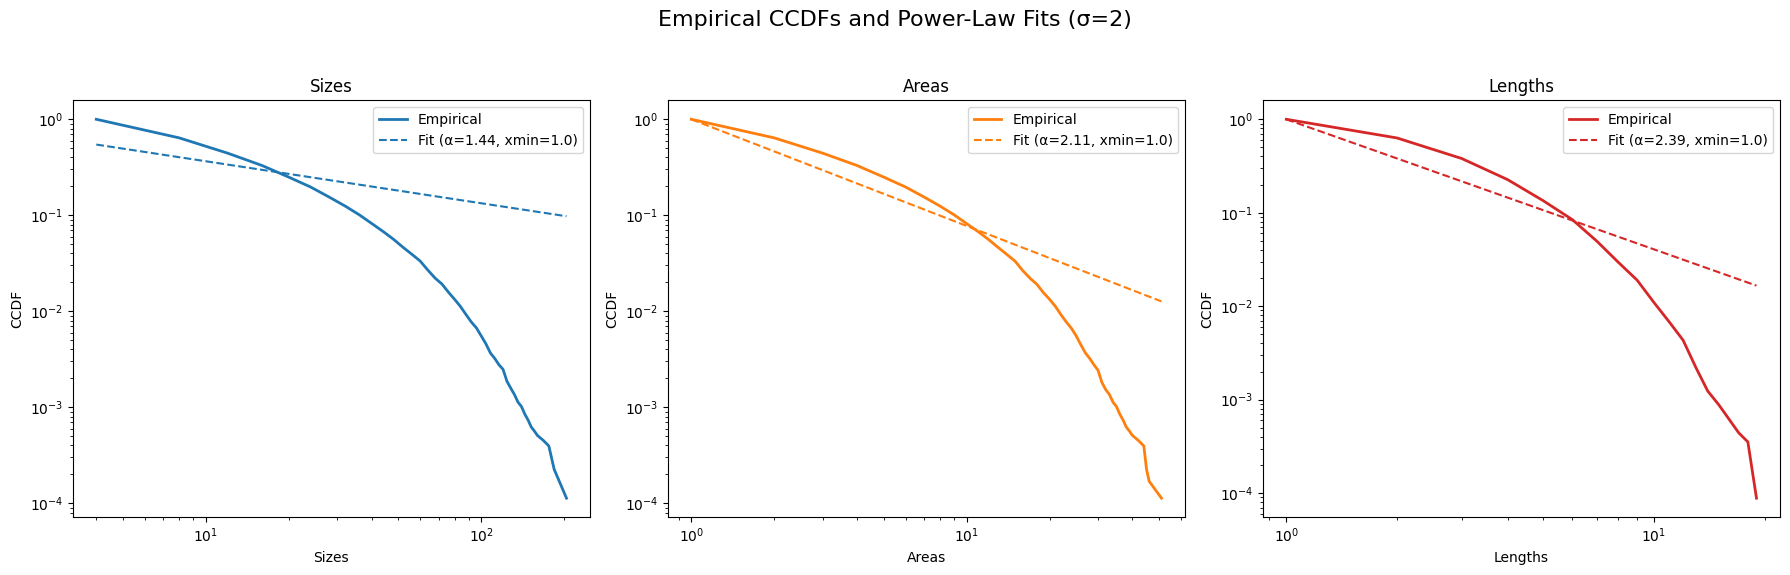

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

# Parameters
sigma0 = 2
T = 100_000
data0 = metrics[sigma0]
metrics_names = ['sizes', 'areas', 'lengths']
colors = ['tab:blue', 'tab:orange', 'tab:red']

# Create a 1×3 subplot layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Empirical CCDFs and Power-Law Fits (σ={sigma0})', fontsize=16)

for ax, m, c in zip(axs, metrics_names, colors):
    # Prepare data
    ts = data0[m][:T]
    ts = ts[ts > 0]  # exclude zeros for fitting

    # Fit power-law
    fit = powerlaw.Fit(ts, xmin=1, verbose=False)
    alpha = fit.power_law.alpha
    xmin = fit.xmin

    # Plot empirical CCDF
    fit.plot_ccdf(ax=ax, color=c, label='Empirical', linewidth=2)
    # Plot fitted power-law CCDF
    fit.power_law.plot_ccdf(
        ax=ax,
        color=c,
        linestyle='--',
        label=f'Fit (α={alpha:.2f}, xmin={xmin})'
    )

    ax.set_title(m.capitalize())
    ax.set_xlabel(m.capitalize())
    ax.set_ylabel('CCDF')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


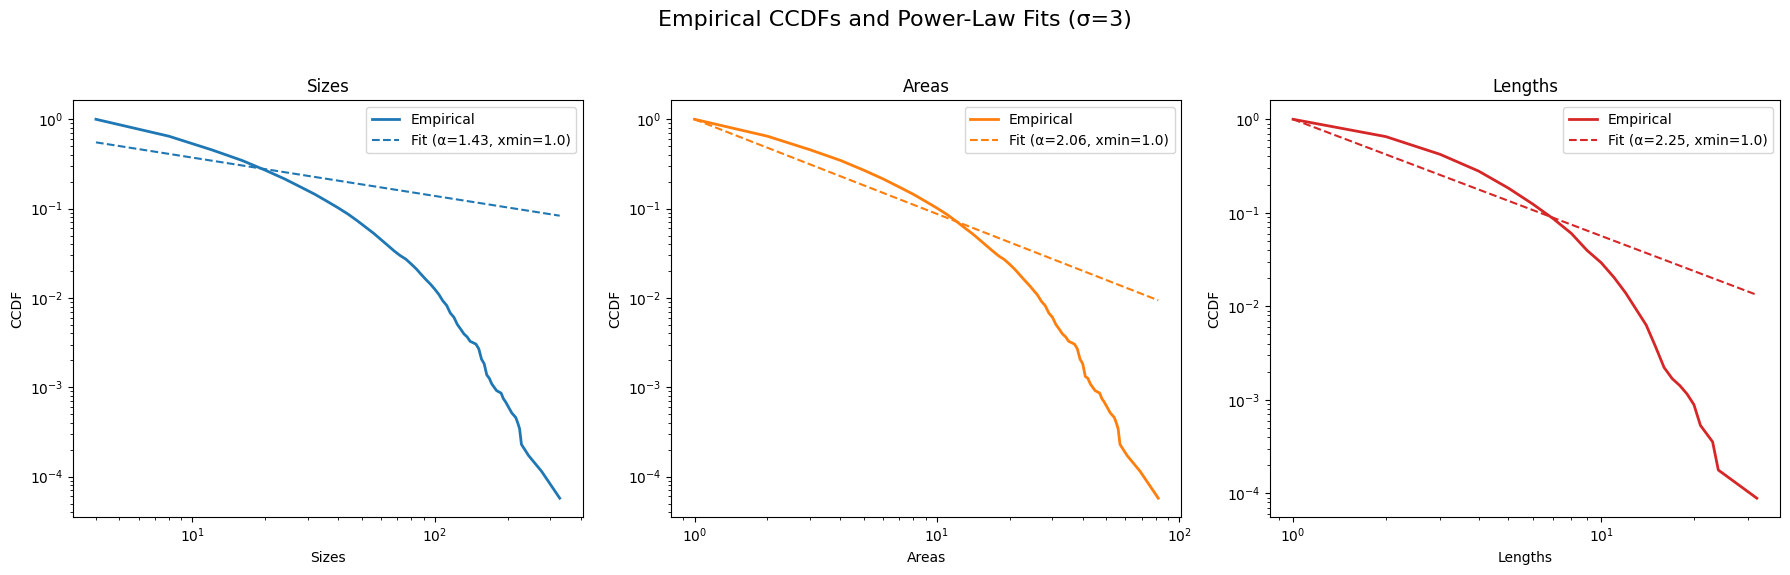

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

# Parameters
sigma0 = 3
T = 100_000
data0 = metrics[sigma0]
metrics_names = ['sizes', 'areas', 'lengths']
colors = ['tab:blue', 'tab:orange', 'tab:red']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Empirical CCDFs and Power-Law Fits (σ={sigma0})', fontsize=16)

for ax, m, c in zip(axs.ravel(), metrics_names, colors):
    # Prepare data
    ts = data0[m][:T]
    ts = ts[ts > 0]  # exclude zeros for fitting

    # Fit power-law
    fit = powerlaw.Fit(ts, xmin=1, verbose=False)
    alpha = fit.power_law.alpha
    xmin = fit.xmin

    # Plot empirical CCDF
    fit.plot_ccdf(ax=ax, color=c, label='Empirical', linewidth=2)
    # Plot fitted power-law CCDF
    fit.power_law.plot_ccdf(ax=ax, color=c, linestyle='--',
                             label=f'Fit (α={alpha:.2f}, xmin={xmin})')

    ax.set_title(m.capitalize())
    ax.set_xlabel(m.capitalize())
    ax.set_ylabel('CCDF')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


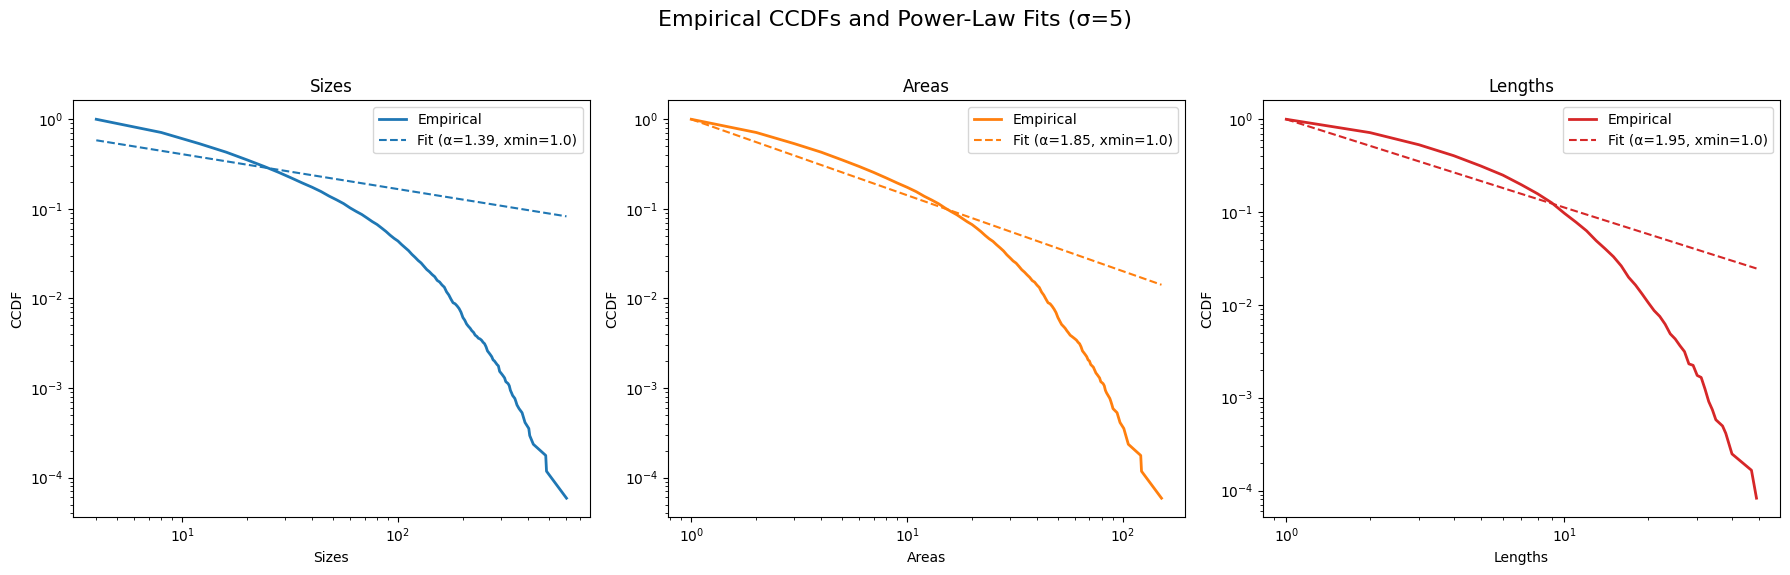

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

# Parameters
sigma0 = 5
T = 100_000
data0 = metrics[sigma0]
metrics_names = ['sizes', 'areas', 'lengths']
colors = ['tab:blue', 'tab:orange', 'tab:red']

# Create a 1×3 subplot layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Empirical CCDFs and Power-Law Fits (σ={sigma0})', fontsize=16)

for ax, m, c in zip(axs, metrics_names, colors):
    # Prepare data
    ts = data0[m][:T]
    ts = ts[ts > 0]  # exclude zeros for fitting

    # Fit power-law
    fit = powerlaw.Fit(ts, xmin=1, verbose=False)
    alpha = fit.power_law.alpha
    xmin = fit.xmin

    # Plot empirical CCDF
    fit.plot_ccdf(ax=ax, color=c, label='Empirical', linewidth=2)
    # Plot fitted power-law CCDF
    fit.power_law.plot_ccdf(
        ax=ax,
        color=c,
        linestyle='--',
        label=f'Fit (α={alpha:.2f}, xmin={xmin})'
    )

    ax.set_title(m.capitalize())
    ax.set_xlabel(m.capitalize())
    ax.set_ylabel('CCDF')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


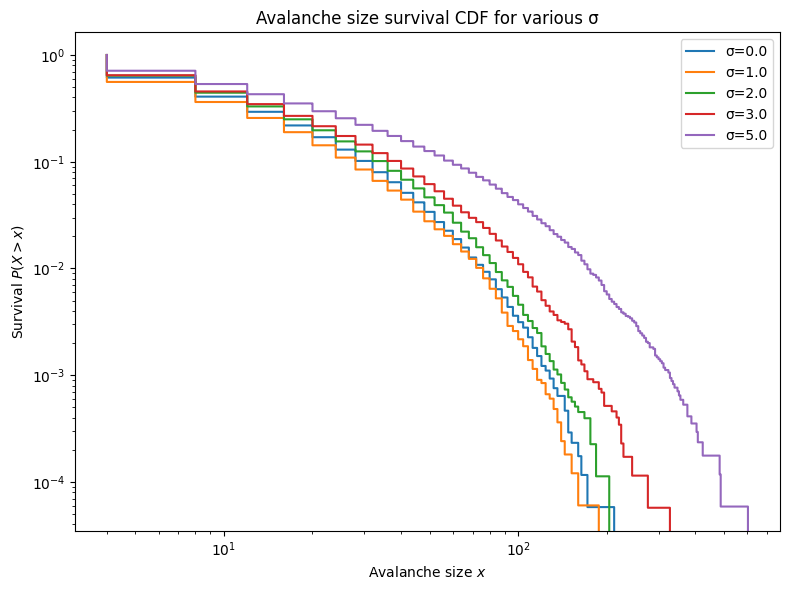

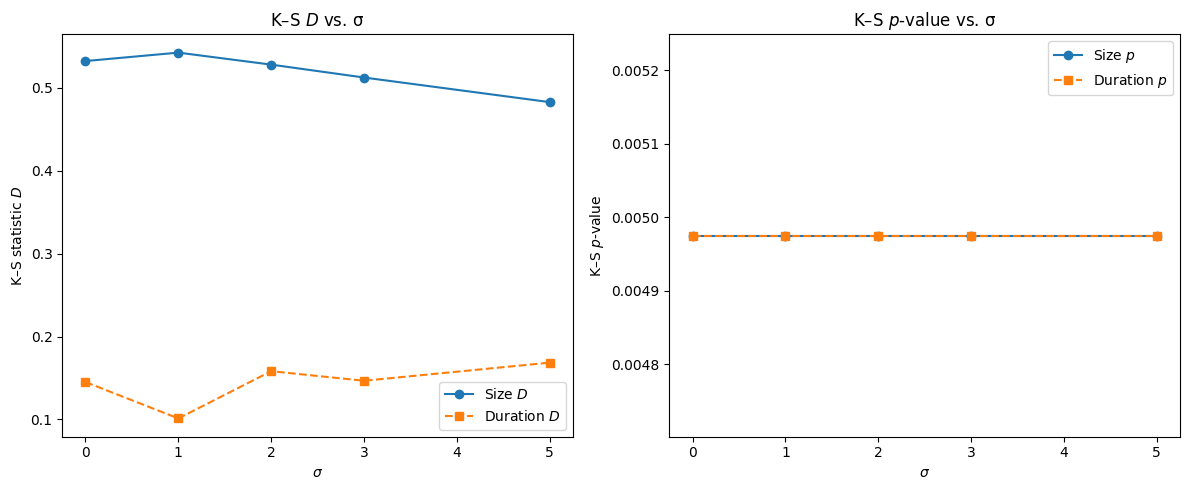

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Empirical CDF (survival) of avalanche sizes for each sigma ---
sigmas = stats['sigma']

plt.figure(figsize=(8,6))
for sigma in sigmas:
    # pull out & clean the size data
    data = metrics[sigma]['sizes']
    data = data[data > 0]                # drop zeros (if any)
    data = np.sort(data)                 # sort ascending
    N = data.size

    # empirical CDF: F(x) = P(X ≤ x), so survival S(x)=1−F(x)
    F = np.arange(1, N+1) / N
    S = 1.0 - F

    # plot survival function as steps on log–log axes
    plt.loglog(data, S, drawstyle='steps-post', label=f'σ={sigma}')

plt.xlabel('Avalanche size $x$')
plt.ylabel(r'Survival $P(X>x)$')
plt.title('Avalanche size survival CDF for various σ')
plt.legend()
plt.tight_layout()
plt.show()


# --- 2. K–S statistic & p‐value vs. sigma ---
sig = stats['sigma']
D_s = stats['D_size']
p_s = stats['p_size']
D_t = stats['D_dur']
p_t = stats['p_dur']

plt.figure(figsize=(12,5))

# D vs sigma
plt.subplot(1,2,1)
plt.plot(sig, D_s, 'o-', label='Size $D$')
plt.plot(sig, D_t, 's--', label='Duration $D$')
plt.xlabel(r'$\sigma$')
plt.ylabel('K–S statistic $D$')
plt.title('K–S $D$ vs. σ')
plt.legend()

# p‐value vs sigma
plt.subplot(1,2,2)
plt.plot(sig, p_s, 'o-', label='Size $p$')
plt.plot(sig, p_t, 's--', label='Duration $p$')
plt.xlabel(r'$\sigma$')
plt.ylabel('K–S $p$-value')
plt.title('K–S $p$-value vs. σ')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import powerlaw
from scipy.stats import f_oneway
# -----------------------------------

def bootstrap_alphas_from_sizes(sizes, xmin, n_boot=30):
    """
    Given the tail array 'sizes' from a full simulation (filtered to exclude zeros)
    and the corresponding xmin, use bootstrap resampling to generate n_boot alpha values.
    """
    tail = sizes[sizes > 0]
    N = len(tail)
    if N == 0:
        return np.array([np.nan] * n_boot)

    alphas = []
    for _ in range(n_boot):
        # 1) Resample with replacement: generate a new sample of the same length as 'tail'
        sample = np.random.choice(tail, size=N, replace=True)
        # 2) Fit a power-law to 'sample' to obtain alpha
        fit = powerlaw.Fit(sample, xmin=xmin, discrete=True, verbose=False)
        alphas.append(fit.power_law.alpha)
    return np.array(alphas)


# -----------------------------------
# 1. First, for each sigma, retrieve the full simulation 'sizes' and fit to find the original xmin
sigma_list = [0, 1.0, 2.0, 3.0, 5.0]
n_boot = 30   # Perform 30 bootstrap resamples for each sigma

all_alphas = {}  # Store the array of alpha values for each sigma

for sigma in sigma_list:
    sizes_full = metrics[sigma]['sizes']
    tail_full = sizes_full[sizes_full > 0]

    # Fit the original tail to find xmin_full
    fit_full = powerlaw.Fit(tail_full, xmin=1, discrete=True, verbose=False)
    xmin_full = int(fit_full.xmin)

    # Use bootstrap_alphas_from_sizes to generate n_boot alpha values
    alphas_boot = bootstrap_alphas_from_sizes(tail_full, xmin_full, n_boot=n_boot)
    all_alphas[sigma] = alphas_boot

    print(f"σ={sigma}: obtained {n_boot} bootstrap alphas, mean = {alphas_boot.mean():.4f}, std = {alphas_boot.std():.4f}")

# -----------------------------------
# 2. Put the alpha values from each group into a list for ANOVA
group_0   = all_alphas[0.0]
group_02  = all_alphas[1.0]
group_05  = all_alphas[2.0]
group_08  = all_alphas[3.0]
group_10  = all_alphas[5.0]

# 3. Perform one-way ANOVA
F_stat, p_val = f_oneway(group_0, group_02, group_05, group_08, group_10)
print(f"\nANOVA result: F = {F_stat:.4f}, p = {p_val:.5f}")

# If p < 0.05, then the mean alphas for different sigma values are significantly different


σ=0: obtained 30 bootstrap alphas, mean = 1.3444, std = 0.0008
σ=1.0: obtained 30 bootstrap alphas, mean = 1.3554, std = 0.0007
σ=2.0: obtained 30 bootstrap alphas, mean = 1.3355, std = 0.0007
σ=3.0: obtained 30 bootstrap alphas, mean = 1.3309, std = 0.0007
σ=5.0: obtained 30 bootstrap alphas, mean = 1.3068, std = 0.0008

ANOVA result: F = 17151.5683, p = 0.00000


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

alphas_all = np.concatenate([all_alphas[s] for s in sigma_list])
labels     = np.concatenate([[s]*n_boot for s in sigma_list])

tukey = pairwise_tukeyhsd(endog=alphas_all, groups=labels, alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0    1.0   0.0111   0.0  0.0106  0.0116   True
   0.0    2.0  -0.0084   0.0 -0.0089 -0.0079   True
   0.0    3.0  -0.0133   0.0 -0.0138 -0.0128   True
   0.0    5.0  -0.0372   0.0 -0.0377 -0.0367   True
   1.0    2.0  -0.0196   0.0 -0.0201 -0.0191   True
   1.0    3.0  -0.0245   0.0  -0.025 -0.0239   True
   1.0    5.0  -0.0483   0.0 -0.0488 -0.0478   True
   2.0    3.0  -0.0049   0.0 -0.0054 -0.0044   True
   2.0    5.0  -0.0287   0.0 -0.0293 -0.0282   True
   3.0    5.0  -0.0239   0.0 -0.0244 -0.0234   True
---------------------------------------------------


In [ ]:
# 8-Neighbor BTW Simulation + ANOVA + Tukey HSD

import torch
import torch.nn.functional as F
import numpy as np
import powerlaw
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device,
      torch.cuda.get_device_name(0) if torch.cuda.is_available() else "")


def discrete_ks_pvalue(data_tail, alpha, xmin, num_sim=200):
    data = np.array(data_tail)
    data = data[data >= xmin].astype(int)
    n = len(data)
    if n == 0:
        return 0.0, 1.0
    xs = np.arange(xmin, data.max() + 1)
    pmf = xs**(-alpha)
    pmf /= pmf.sum()
    cdf_model = np.cumsum(pmf)
    freqs = np.bincount(data - xmin, minlength=len(xs))
    cdf_emp = np.cumsum(freqs) / n
    D_obs = np.max(np.abs(cdf_emp - cdf_model))
    count = 0
    for _ in range(num_sim):
        synth = np.random.choice(xs, size=n, p=pmf)
        freqs_sim = np.bincount(synth - xmin, minlength=len(xs))
        cdf_sim = np.cumsum(freqs_sim) / n
        if np.max(np.abs(cdf_sim - cdf_model)) >= D_obs:
            count += 1
    return D_obs, (count + 1) / (num_sim + 1)

def simulate_btw_8neigh(L, sigma, n_drops, burn_in, device):
    """
    8-邻 BTW with fractional bias, threshold=8, unbiased 8-neighbor conv.
    """
    # grid and remainder
    grid = torch.zeros((1,1,L,L), dtype=torch.float32, device=device)
    remainder = torch.zeros_like(grid)
    # unbiased kernel: 3x3 ones except center zero
    kernel_unb = torch.ones((1,1,3,3), dtype=torch.float32, device=device)
    kernel_unb[0,0,1,1] = 0.0

    sizes, durations = [], []

    for drop in tqdm(range(n_drops), desc=f"σ={sigma}"):
        i = torch.randint(0, L, (1,), device=device).item()
        j = torch.randint(0, L, (1,), device=device).item()
        grid[0,0,i,j] += 1.0

        # avalanche stats
        size = 0
        dur = 0

        while True:
            unstable = grid >= 8.0
            if not unstable.any():
                break
            dur += 1
            # topple count
            T = torch.floor(grid / 8.0)
            # remove 8*T
            grid = grid - 8.0 * T
            # unbiased distribution
            du = F.conv2d(T, kernel_unb, padding=1)
            grid = grid + du
            # fractional bias distribution of 8σ/(8+σ)
            bias_float = (8.0 * sigma / (8.0 + sigma)) * T
            remainder = remainder + bias_float
            B = torch.floor(remainder)
            remainder = remainder - B
            grid = grid + B
            # record size ~ topple count * 8
            size += int((T.sum() * 8.0).item())

        # record
        if drop >= burn_in:
            sizes.append(size)
            durations.append(dur)

    return np.array(sizes), np.array(durations)

sigma_list = [0.0, 1.0, 2.0, 3.0, 5.0]
n_drops = 190_000
burn_in = 140_000
metrics2 = {}
all_alphas = {}
print("\n=== Fitting and Bootstrapping α ===")
for sigma in sigma_list:
    sizes, durs = simulate_btw_8neigh(256, sigma, n_drops, burn_in, device)
    tail = sizes[sizes>0]
    fit = powerlaw.Fit(tail, xmin=1, discrete=True, verbose=False)
    xmin = int(fit.xmin)
    # bootstrap
    alphas = []
    for _ in range(30):
        sample = np.random.choice(tail, size=len(tail), replace=True)
        fb = powerlaw.Fit(sample, xmin=xmin, discrete=True, verbose=False)
        alphas.append(fb.power_law.alpha)
    all_alphas[sigma] = np.array(alphas)
    print(f"σ={sigma}: mean α={np.mean(alphas):.4f}, std={np.std(alphas):.4f}")
    metrics2[sigma] = {
            'sizes': sizes

        }

# 5. ANOVA
groups = [all_alphas[s] for s in sigma_list]
F_stat, p_val = f_oneway(*groups)
print(f"\nANOVA: F={F_stat:.4f}, p={p_val:.2e}")

# 6. Tukey's HSD
alphas_all = np.concatenate(groups)
labels = np.concatenate([[s]*len(groups[i]) for i,s in enumerate(sigma_list)])
tukey = pairwise_tukeyhsd(endog=alphas_all, groups=labels, alpha=0.05)
print("\nTukey HSD results:")
print(tukey)


Using device: cuda Tesla T4

=== Fitting and Bootstrapping α ===


σ=0.0: 100%|██████████| 190000/190000 [00:31<00:00, 5999.76it/s]


σ=0.0: mean α=1.3497, std=0.0012


σ=1.0: 100%|██████████| 190000/190000 [00:31<00:00, 6054.88it/s]


σ=1.0: mean α=1.3500, std=0.0013


σ=2.0: 100%|██████████| 190000/190000 [00:31<00:00, 6033.22it/s]


σ=2.0: mean α=1.3485, std=0.0013


σ=3.0: 100%|██████████| 190000/190000 [00:31<00:00, 6032.27it/s]


σ=3.0: mean α=1.3469, std=0.0014


σ=5.0: 100%|██████████| 190000/190000 [00:31<00:00, 5979.74it/s]


σ=5.0: mean α=1.3496, std=0.0012

ANOVA: F=27.7471, p=4.11e-17

Tukey HSD results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    1.0   0.0004 0.8051 -0.0006  0.0013  False
   0.0    2.0  -0.0012 0.0055 -0.0021 -0.0003   True
   0.0    3.0  -0.0027    0.0 -0.0037 -0.0018   True
   0.0    5.0     -0.0    1.0  -0.001  0.0009  False
   1.0    2.0  -0.0016 0.0001 -0.0025 -0.0006   True
   1.0    3.0  -0.0031    0.0 -0.0041 -0.0022   True
   1.0    5.0  -0.0004  0.777 -0.0013  0.0006  False
   2.0    3.0  -0.0015 0.0001 -0.0025 -0.0006   True
   2.0    5.0   0.0012 0.0065  0.0002  0.0021   True
   3.0    5.0   0.0027    0.0  0.0018  0.0037   True
----------------------------------------------------


In [ ]:
print("end")

end
